In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
from sklearn import svm
import os
import pandas as pd
import xml.etree.ElementTree as et
import glob
import spacy
from collections import namedtuple
import string

In [203]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser"])

Pair = namedtuple("Pair", ["t", "h"])

# Store list of punctuation marks to ignore
PUNCT = string.punctuation
NEGATIONS = set(['deny','fail','never','no','nobody','not','nothing','reject',
                 'without', 'noone', 'none', 'cannot', 'nor','n‘t', 'n’t'])
STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS - NEGATIONS
feat_cols = ["w_overlap", "w_hyp_extra", "w_jaccard", "ne_overlap", "ne_hyp_extra", 'neg', 'jc_m', 'sim']


def preprocess_sentence(sentence):
    """
    Preprocess a sentence by removing stop words and punctuations, and lemmatizing
    Args: 
        sentence (string): full sentence string
    Returns:
        processed_sentence (list): list of processed tokens
    """

    doc = nlp(sentence)
    processed_sentence = []
    named_entities = []

    # filtering stop words and lemmatizing
    for word in doc:
        if (word not in STOP_WORDS and word.text not in PUNCT):
            processed_sentence.append(word.lemma_.lower().strip())

    # Named entitities recognized
    for word in doc.ents:
        named_entities.append(word.text.strip())

    return doc, processed_sentence, named_entities


def overlap(pair):
    """
        Compute the overlap material
        """
    return len(set(pair.t).intersection(pair.h))


def hyp_extra(pair):
    """
        Compute the number of words occuring in hyp but not in text
        """
    return len(set(pair.h) - set(pair.t))

def neg_feature(pair):
    """
        Compute the number of words occuring in hyp but not in text
    """
    b = 0
    for w in pair.t:
        if w in NEGATIONS:
            b = 1
    for w in pair.h:
        if w in NEGATIONS:
            return 0
    return b


def preprocess_pair(text, hyp):
    """
    Preprocess pair of text and hypothesis
    Args:
        text (string): text sentence 
        hyp (string): hypothesis sentence to compare to text
    Returns:
        features (tuple): tuple of features that can be used
            for predictions
    """
    # process the text and hyp sententences
    t_doc_obj, text_proc, text_ne = preprocess_sentence(text)
    h_doc_obj, hyp_proc, hyp_ne = preprocess_sentence(hyp)

    # get features by using preprocessed sentences
    word_pair = Pair(text_proc, hyp_proc)
    w_overlap = overlap(word_pair)
    w_hyp_extra = hyp_extra(word_pair)

    # jaccard similarity between the text and h
    w_jaccard = w_overlap / (len(word_pair.t) + len(word_pair.h))

    # min sim
    w_jaccard_s = w_overlap / min((len(word_pair.t), len(word_pair.h)))
    
    sim = t_doc_obj.similarity(h_doc_obj)

    # get features by using the named entity recognized
    ne_pair = Pair(text_ne, hyp_ne)
    ne_overlap = overlap(ne_pair)
    ne_hyp_extra = hyp_extra(ne_pair)
    
    n = neg_feature(word_pair)

    return (w_overlap, w_hyp_extra, w_jaccard, ne_overlap, ne_hyp_extra, n, w_jaccard_s, sim)

In [204]:
def get_pandas_from_xml(xml_path):
    """
    Parses the RET datasets to return a pandas dataframe
    Args:
        xml_path (string): path at which xml file is stored
    Returns:
        out_df (pd.DataFrame): dataframe containing dataset extracted from xml
    """
    xtree = et.parse(xml_path)
    xroot = xtree.getroot()
    df_cols = ["id", "t", "h", "entailment", "task"]
    out_df = pd.DataFrame(columns=df_cols)

    # map labels to desired categories
    threeway_dict = {"YES": "AGREE", "NO": "CONTRADICTS", "UNKNOWN": "UNRELATED"}
    contra_dict = {"YES": "CONTRADICTS", "NO": "UNRELATED"}

    for node in xroot:
        node_t = node.find("t").text
        node_h = node.find("h").text
        node_id = node.attrib.get("id")

        if node.attrib.get("entailment") is not None:
            node_entailement = threeway_dict[node.attrib.get("entailment")]
        else:
            # In the case of using the contradiction dataset
            # In terms of 3-way decision, the contradiction="YES" items
            # should be mapped to entailment="NO",
            # and the contradiction="NO" to entailment="UNKNOWN".
            node_entailement = contra_dict[node.attrib.get("contradiction")]

        if node.attrib.get("task") is not None:
            node_task = node.attrib.get("task")
        elif node.attrib.get("type") is not None:
            node_task = node.attrib.get("type")
        else:
            node_task = "missing"

        out_df = out_df.append(
            pd.Series(
                [node_id, node_t, node_h, node_entailement, node_task], index=df_cols
            ),
            ignore_index=True,
        )

    return out_df


def process_dataset(pd_df):
    """
    Process a pandas dataset and return the pandas df 
    with new columns for features and processed pair
    """
    pd_df["entailment"] = pd_df["entailment"].astype("category")
    proc_pairs = [
        preprocess_pair(t, h) for t, h in zip(list(pd_df["t"]), list(pd_df["h"]))
    ]
    features_pd = pd.DataFrame(proc_pairs, columns=feat_cols)
    pd_df = pd.concat([pd_df, features_pd], axis=1, sort=False)
    return pd_df


def get_dataset():
    """
    Get a dataset based on all the xml dataset files
    """
    all_files = glob.glob("datasets/*")
    all_dfs = []
    for f in all_files:
        temp_pd = get_pandas_from_xml(f)
        temp_pd = process_dataset(temp_pd)
        all_dfs.append(temp_pd)
    dataset = pd.concat(all_dfs, axis=0, sort=False)
    return dataset


In [205]:
%%time 
dataset = get_dataset()

CPU times: user 38.4 s, sys: 409 ms, total: 38.8 s
Wall time: 39.2 s


In [206]:
dataset.head()

,id,t,h,entailment,task,w_overlap,w_hyp_extra,w_jaccard,ne_overlap,ne_hyp_extra,neg,jc_m,sim
0,3,"ECB spokeswoman, Regina Schueller, declined to...",Regina Shueller works for Italy's La Repubblic...,CONTRADICTS,IE,6,3,0.136364,2,1,0,0.666667,0.768258
1,4,"Meanwhile, in an exclusive interview with a TI...","Ahmedinejad was attacked by the US, France, Br...",UNRELATED,IE,8,2,0.121212,4,1,0,0.800000,0.862379
2,11,The chaotic situation unleashed in Bogota last...,Justice Carlos Valencia was killed on 28 July.,CONTRADICTS,IE,6,2,0.146341,2,0,0,0.750000,0.868222
3,12,"He met U.S. President, George W. Bush, in Wash...",Washington is part of London.,UNRELATED,IE,2,3,0.090909,2,0,0,0.400000,0.788237
4,13,Sunday's earthquake was felt in the southern I...,The city of Madras is located in Southern India.,AGREE,IE,8,1,0.156863,1,1,0,0.888889,0.906983


In [207]:
# sum(dataset['anto'].values)

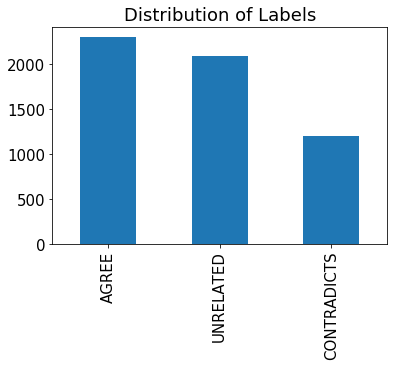

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = dataset['entailment'].value_counts().plot(kind='bar')
ax.set_title("Distribution of Labels")
plt.show()

In [209]:
import numpy as np
np.random.seed(42) 
train, test = train_test_split(dataset, stratify=dataset['entailment'])

In [210]:
feat_cols = ["w_overlap", "w_hyp_extra", "w_jaccard", "ne_overlap", "ne_hyp_extra", 'neg', 'jc_m', 'sim']
clf = LogisticRegression(random_state=0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf.fit(train[feat_cols], train['entailment'])  
y_pred = clf.predict(test[feat_cols])
precision, recall, fscore, _ = precision_recall_fscore_support(test['entailment'], y_pred)
print("Precision: {} \tRecall: {}\tF1-Score: {} \tMean Accuracy: {}".format(precision.mean(), 
                                                                            recall.mean(), 
                                                                            fscore.mean(), 
                                                                            round(clf.score(test[feat_cols],
                                                                                            test['entailment']), 4)))


Precision: 0.5892041581582541 	Recall: 0.42155828137377455	F1-Score: 0.37922776603116076 	Mean Accuracy: 0.4964


In [212]:
feat_cols = ["w_overlap", "w_hyp_extra", "w_jaccard", 'neg']
clf = LogisticRegression(random_state=55, multi_class='ovr', solver='lbfgs')
clf.fit(train[feat_cols], train['entailment'])  
y_pred = clf.predict(test[feat_cols])
precision, recall, fscore, _ = precision_recall_fscore_support(test['entailment'], y_pred)
print("Precision: {} \tRecall: {}\tF1-Score: {} \tMean Accuracy: {}".format(precision.mean(), 
                                                                            recall.mean(), 
                                                                            fscore.mean(), 
                                                                            round(clf.score(test[feat_cols],
                                                                                            test['entailment']), 4)))



Precision: 0.32719890579733557 	Recall: 0.41311034983358114	F1-Score: 0.36232769520083524 	Mean Accuracy: 0.4907


# Testing different classifiers

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0, multi_class='ovr', solver='lbfgs'),
    MLPClassifier(max_iter=10000)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train[feat_cols], train['entailment'], scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

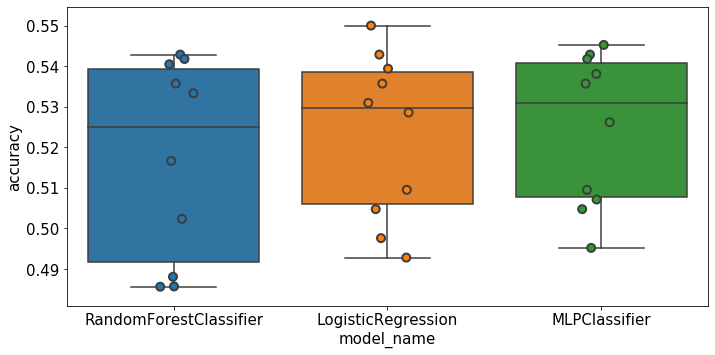

In [214]:
plt.rcParams.update({'font.size': 15})

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

fig = plt.gcf()
fig.set_size_inches(11.5, 5.5)
plt.show()

In [86]:
preprocess_sentence("The red fox did not jump over the lazy dog")

(['red', 'fox', 'not', 'jump', 'lazy', 'dog'], [])

The
did
over
the
['red', 'fox', 'not', 'jump', 'lazy', 'dog']


In [115]:

import nltk 
# nltk.download('wordnet')
from nltk.corpus import wordnet 
synonyms = [] 
antonyms = [] 
  
for syn in wordnet.synsets("good"): 
    for l in syn.lemmas(): 
        synonyms.append(l.name()) 
        if l.antonyms(): 
            antonyms.append(l.antonyms()[0].name()) 
  
print(set(synonyms)) 
print(set(antonyms)) 


{'goodness', 'soundly', 'near', 'honorable', 'safe', 'in_effect', 'estimable', 'effective', 'secure', 'thoroughly', 'unspoiled', 'upright', 'respectable', 'practiced', 'dependable', 'sound', 'expert', 'trade_good', 'well', 'right', 'skilful', 'just', 'unspoilt', 'undecomposed', 'ripe', 'serious', 'honest', 'proficient', 'skillful', 'full', 'beneficial', 'dear', 'salutary', 'adept', 'commodity', 'in_force', 'good'}
{'evil', 'evilness', 'badness', 'ill', 'bad'}


{'denied',
 'deny',
 'fail',
 'failed',
 'never',
 'no',
 'nobody',
 'not',
 'nothing',
 'reject',
 'rejected',
 'without'}